In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.95

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   massa
   2   alessandria
   3   benevento
   4   caltanissetta
   5   viterbo
   6   pesaro
   7   teramo
   8   foggia
   9   milano
   10   enna
   11   arezzo
   12   pavia
   13   ancona
   14   parma
   15   prato
   16   imperia
   17   padova
   18   bologna
   19   ascoli_piceno
   20   vercelli
   21   terni
   22   lodi
   23   catania
   24   venezia
   25   perugia
   26   novara
   27   potenza
   28   nuoro
   29   pisa
   30   carbonia
   31   pistoia
   32   taranto
   33   savona
   34   rovigo
   35   piacenza
   36   asti
   37   sondrio
   38   verbania
   39   ferrara
   40   brescia
   41   siracusa
   42   cuneo
   43   bari
   44   pordenone
   45   ragusa
   46   reggio_nell_emilia
   47   como
   48   vibo_valentia
   49   salerno
   50   udine
   51   palermo
   52   mantova
   53   monza
   54   fermo
   55   trento
   56   roma
   57   bat
   58   biella
   59   cremona
   60  

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 massa
2 alessandria
3 benevento
4 caltanissetta
5 viterbo
6 pesaro
7 teramo
8 foggia
9 milano
10 enna
11 arezzo
12 pavia
13 ancona
14 parma
15 prato
16 imperia
17 padova
18 bologna
19 ascoli_piceno
20 vercelli
21 terni
22 lodi
23 catania
24 venezia
25 perugia
26 novara
27 potenza
28 nuoro
29 pisa
30 pistoia
31 taranto
32 savona
33 rovigo
34 piacenza
35 asti
36 sondrio
37 verbania
38 ferrara
39 brescia
40 siracusa
41 cuneo
42 bari
43 pordenone
44 ragusa
45 reggio_nell_emilia
46 como
47 vibo_valentia
48 salerno
49 udine
50 palermo
51 mantova
52 monza
53 fermo
54 trento
55 roma
56 bat
57 biella
58 cremona
59 gorizia
60 rieti
61 cagliari
62 siena
63 grosseto
64 verona
65 pescara
66 caserta
67 matera
68 agrigento
69 macerata
70 chieti
71 crotone
72 messina
73 l_aquila
74 latina
75 napoli
76 trapani
77 frosinone
78 ravenna
79 livorno
80 avellino
81 treviso
82 brindisi
83 campobasso
84 oristano
85 catanzaro
86 lucca
87 belluno
88 vicenza
89 genova
90 rimini
91 varese
92 reggio_di_calabria
9

In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.35329  0.02080 
    Test set average RMSE:  0.94039  0.08981 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.34337
                       R2:  0.94605


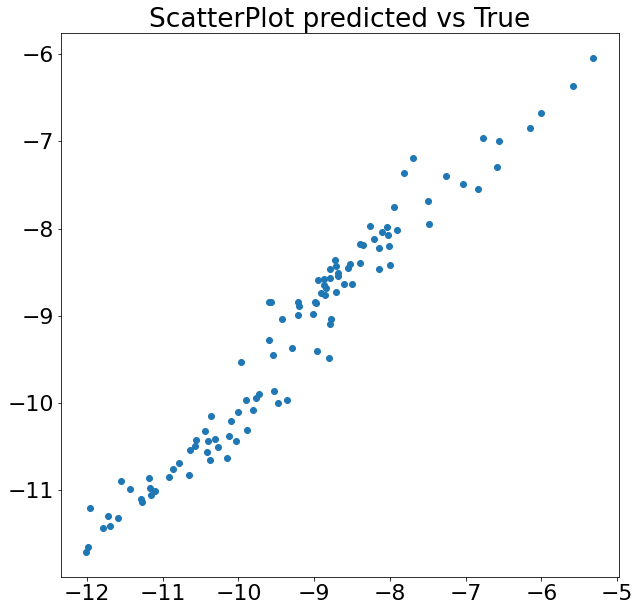

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02163
Feature:               commutersdensity, Score: 0.00864
Feature:                         depriv, Score: 0.01720
Feature:                            lat, Score: 0.65011
Feature:                 Ratio0200ver65, Score: 0.04186
Feature:         avg_wpm10_period1_2020, Score: 0.04396
Feature:          avg_wnh3_period1_2020, Score: 0.04891
Feature:        avg_wnmvoc_period1_2020, Score: 0.02028
Feature:           avg_wno_period1_2020, Score: 0.04425
Feature:           avg_wo3_period1_2020, Score: 0.03932
Feature:         avg_wpans_period1_2020, Score: 0.02073
Feature:          avg_wso2_period1_2020, Score: 0.02281
Feature:                  randomfeature, Score: 0.02030


<Figure size 432x288 with 0 Axes>

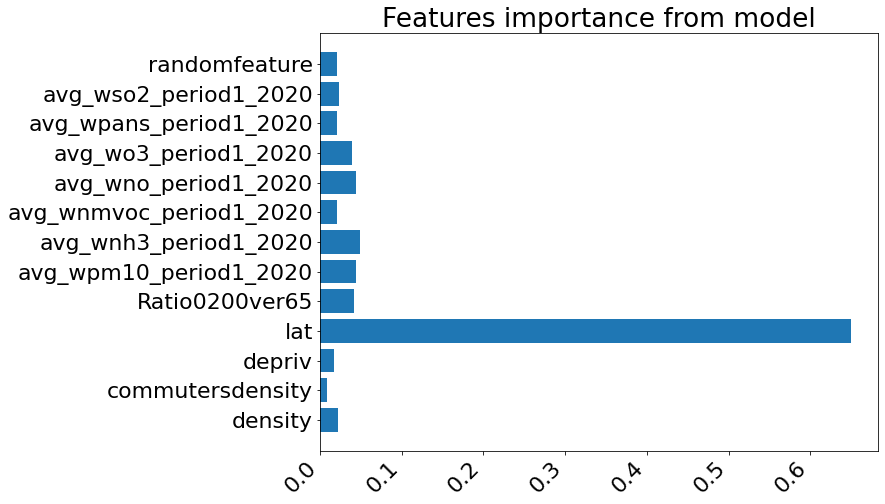

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.02988 +/- 0.00361
Feature:               commutersdensity, Score: 0.01768 +/- 0.00220
Feature:                         depriv, Score: 0.03422 +/- 0.00372
Feature:                            lat, Score: 2.58500 +/- 0.35856
Feature:                 Ratio0200ver65, Score: 0.12394 +/- 0.01670
Feature:         avg_wpm10_period1_2020, Score: 0.09314 +/- 0.01516
Feature:          avg_wnh3_period1_2020, Score: 0.11227 +/- 0.01451
Feature:        avg_wnmvoc_period1_2020, Score: 0.03697 +/- 0.00594
Feature:           avg_wno_period1_2020, Score: 0.08311 +/- 0.01138
Feature:           avg_wo3_period1_2020, Score: 0.08642 +/- 0.00960
Feature:         avg_wpans_period1_2020, Score: 0.03800 +/- 0.00449
Feature:          avg_wso2_period1_2020, Score: 0.05415 +/- 0.00793
Feature:                  randomfeature, Score: 0.03774 +/- 0.00360


<Figure size 432x288 with 0 Axes>

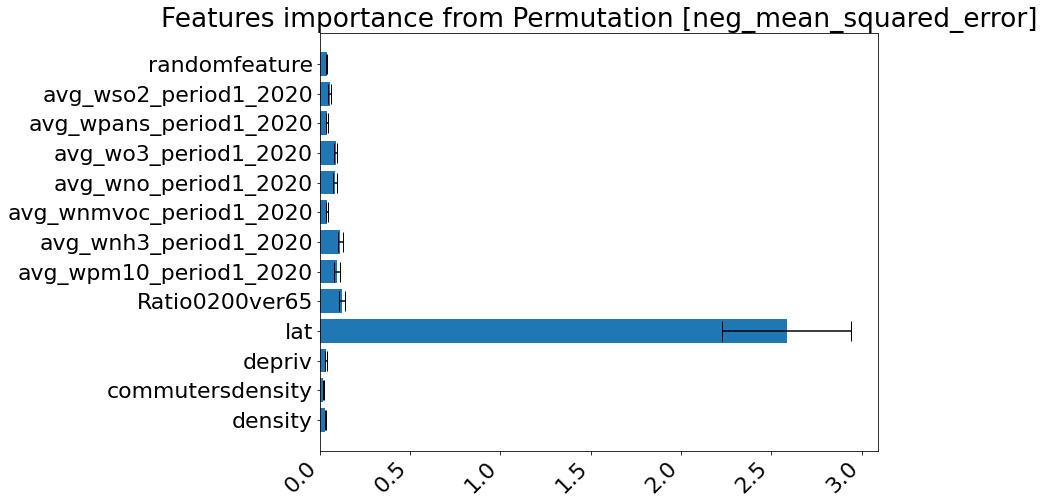

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.01367 +/- 0.00165
Feature:               commutersdensity, Score: 0.00809 +/- 0.00101
Feature:                         depriv, Score: 0.01566 +/- 0.00170
Feature:                            lat, Score: 1.18293 +/- 0.16408
Feature:                 Ratio0200ver65, Score: 0.05672 +/- 0.00764
Feature:         avg_wpm10_period1_2020, Score: 0.04262 +/- 0.00694
Feature:          avg_wnh3_period1_2020, Score: 0.05138 +/- 0.00664
Feature:        avg_wnmvoc_period1_2020, Score: 0.01692 +/- 0.00272
Feature:           avg_wno_period1_2020, Score: 0.03803 +/- 0.00521
Feature:           avg_wo3_period1_2020, Score: 0.03955 +/- 0.00440
Feature:         avg_wpans_period1_2020, Score: 0.01739 +/- 0.00205
Feature:          avg_wso2_period1_2020, Score: 0.02478 +/- 0.00363
Feature:                  randomfeature, Score: 0.01727 +/- 0.00165


<Figure size 432x288 with 0 Axes>

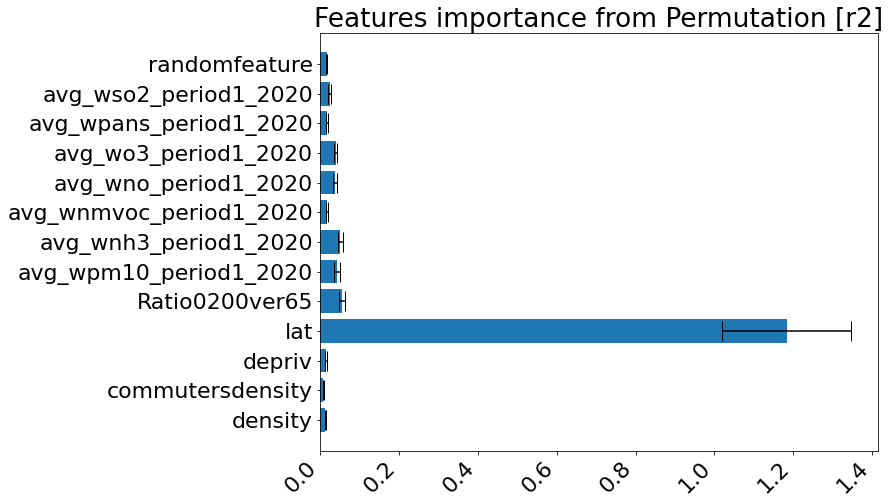

<Figure size 720x720 with 0 Axes>

((0.35329153017344, 0.020795198377322285),
 (0.9403913088637964, 0.08980625153666821),
 0.343370450139088,
 {'density': 0.008966612213430446,
  'commutersdensity': 0.0053040617688174235,
  'depriv': 0.010268128700224104,
  'lat': 0.77569326653212,
  'Ratio0200ver65': 0.03719039431012798,
  'avg_wpm10_period1_2020': 0.027948431148038466,
  'avg_wnh3_period1_2020': 0.033689226582457224,
  'avg_wnmvoc_period1_2020': 0.011093661430538158,
  'avg_wno_period1_2020': 0.024939220708662592,
  'avg_wo3_period1_2020': 0.02593142149650022,
  'avg_wpans_period1_2020': 0.01140335537146778,
  'avg_wso2_period1_2020': 0.016248680292520405,
  'randomfeature': 0.011323539445095161},
 {'density': 0.008966612213430463,
  'commutersdensity': 0.005304061768817442,
  'depriv': 0.010268128700224118,
  'lat': 0.7756932665321199,
  'Ratio0200ver65': 0.037190394310127994,
  'avg_wpm10_period1_2020': 0.027948431148038477,
  'avg_wnh3_period1_2020': 0.03368922658245724,
  'avg_wnmvoc_period1_2020': 0.0110936614305

In [6]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures", showplot=True)

In [7]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.11790326602871994
2  of  1200 MSE:  0.11361229462987762
3  of  1200 MSE:  0.1625498175234377
4  of  1200 MSE:  0.20609895615716373
5  of  1200 MSE:  0.3825672232011871
6  of  1200 MSE:  0.49089296487798645
7  of  1200 MSE:  0.5757520846762865
8  of  1200 MSE:  0.7068061938593094
9  of  1200 MSE:  0.15968629294569817
10  of  1200 MSE:  0.18171792403912307
11  of  1200 MSE:  0.1801471617275317
12  of  1200 MSE:  0.23461302258247477
13  of  1200 MSE:  0.3825672232011871
14  of  1200 MSE:  0.49089296487798645
15  of  1200 MSE:  0.5757520846762865
16  of  1200 MSE:  0.7068061938593094
17  of  1200 MSE:  0.26157394069597895
18  of  1200 MSE:  0.3261344420921609
19  of  1200 MSE:  0.27377364538152277
20  of  1200 MSE:  0.35159085087317593
21  of  1200 MSE:  0.3825672232011871
22  of  1200 MSE:  0.49089296487798645
23  of  1200 MSE:  0.5757520846762865
24  of  1200 MSE:  0.7068061938593094
25  of  1200 MSE:  0.3652719106273695
26  of  1200 MSE:  0.4220638290067665
27  of  1

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500,
 'random_state': 1}
Training set average RMSE:  0.34071  0.02024 
    Test set average RMSE:  0.93291  0.09995 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.32945
                       R2:  0.95033


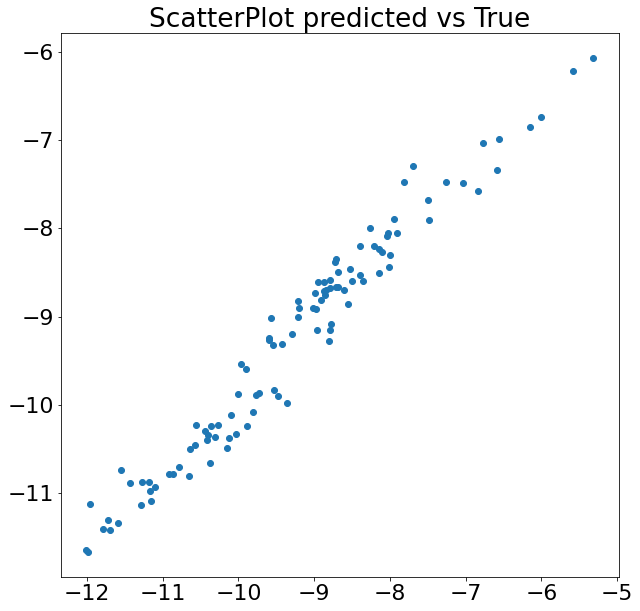

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02708
Feature:               commutersdensity, Score: 0.13136
Feature:                         depriv, Score: 0.07636
Feature:                            lat, Score: 0.21986
Feature:                 Ratio0200ver65, Score: 0.04037
Feature:         avg_wpm10_period1_2020, Score: 0.09332
Feature:          avg_wnh3_period1_2020, Score: 0.06736
Feature:        avg_wnmvoc_period1_2020, Score: 0.08215
Feature:           avg_wno_period1_2020, Score: 0.10773
Feature:           avg_wo3_period1_2020, Score: 0.06481
Feature:         avg_wpans_period1_2020, Score: 0.02993
Feature:          avg_wso2_period1_2020, Score: 0.03665
Feature:                  randomfeature, Score: 0.02303


<Figure size 432x288 with 0 Axes>

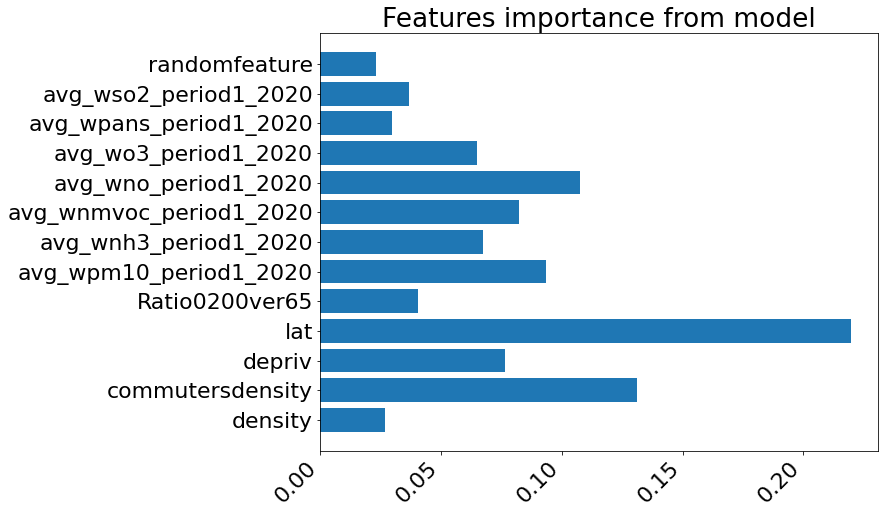

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.03173 +/- 0.00322
Feature:               commutersdensity, Score: 0.02575 +/- 0.00352
Feature:                         depriv, Score: 0.04315 +/- 0.00400
Feature:                            lat, Score: 2.68944 +/- 0.37132
Feature:                 Ratio0200ver65, Score: 0.10247 +/- 0.01551
Feature:         avg_wpm10_period1_2020, Score: 0.10609 +/- 0.01429
Feature:          avg_wnh3_period1_2020, Score: 0.09998 +/- 0.01440
Feature:        avg_wnmvoc_period1_2020, Score: 0.05800 +/- 0.00922
Feature:           avg_wno_period1_2020, Score: 0.09300 +/- 0.01454
Feature:           avg_wo3_period1_2020, Score: 0.08490 +/- 0.01064
Feature:         avg_wpans_period1_2020, Score: 0.03253 +/- 0.00428
Feature:          avg_wso2_period1_2020, Score: 0.04313 +/- 0.00539
Feature:                  randomfeature, Score: 0.04055 +/- 0.00535


<Figure size 432x288 with 0 Axes>

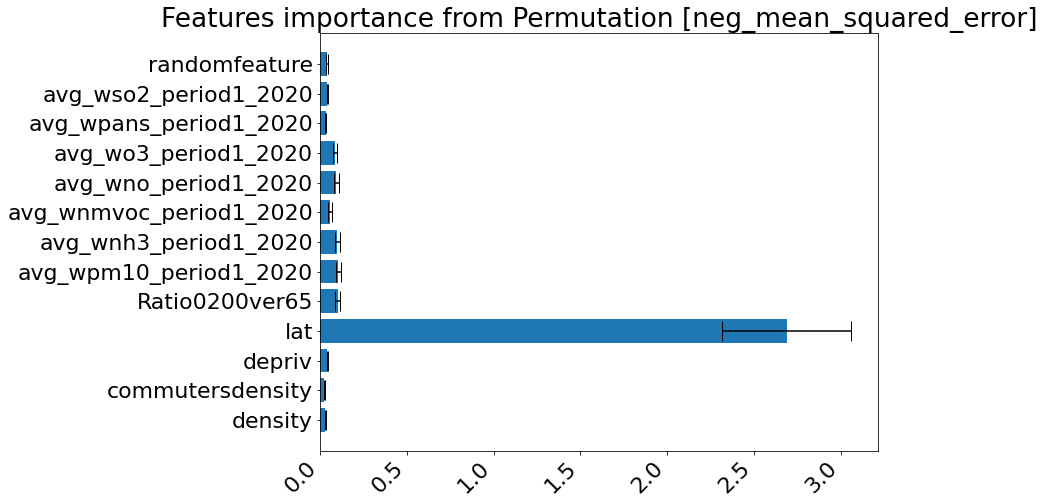

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.01452 +/- 0.00147
Feature:               commutersdensity, Score: 0.01178 +/- 0.00161
Feature:                         depriv, Score: 0.01975 +/- 0.00183
Feature:                            lat, Score: 1.23073 +/- 0.16992
Feature:                 Ratio0200ver65, Score: 0.04689 +/- 0.00710
Feature:         avg_wpm10_period1_2020, Score: 0.04855 +/- 0.00654
Feature:          avg_wnh3_period1_2020, Score: 0.04575 +/- 0.00659
Feature:        avg_wnmvoc_period1_2020, Score: 0.02654 +/- 0.00422
Feature:           avg_wno_period1_2020, Score: 0.04256 +/- 0.00665
Feature:           avg_wo3_period1_2020, Score: 0.03885 +/- 0.00487
Feature:         avg_wpans_period1_2020, Score: 0.01488 +/- 0.00196
Feature:          avg_wso2_period1_2020, Score: 0.01974 +/- 0.00247
Feature:                  randomfeature, Score: 0.01855 +/- 0.00245


<Figure size 432x288 with 0 Axes>

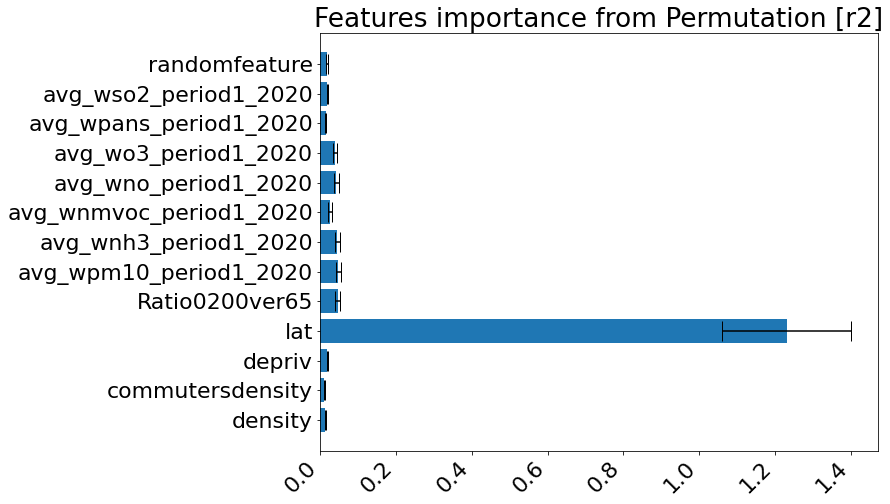

<Figure size 720x720 with 0 Axes>

((0.3407072177117558, 0.020244516792278306),
 (0.9329061086470289, 0.09994501666463979),
 0.3294505427217716,
 {'density': 0.009196604606417583,
  'commutersdensity': 0.007462221797857572,
  'depriv': 0.012504966849717346,
  'lat': 0.7793864662327576,
  'Ratio0200ver65': 0.029695992565488105,
  'avg_wpm10_period1_2020': 0.03074500405022911,
  'avg_wnh3_period1_2020': 0.02897428373343404,
  'avg_wnmvoc_period1_2020': 0.01680748250928265,
  'avg_wno_period1_2020': 0.026950152519564865,
  'avg_wo3_period1_2020': 0.024602407911165313,
  'avg_wpans_period1_2020': 0.009425831141060792,
  'avg_wso2_period1_2020': 0.012498285319326372,
  'randomfeature': 0.0117503007636987},
 {'density': 0.009196604606417545,
  'commutersdensity': 0.007462221797857541,
  'depriv': 0.012504966849717315,
  'lat': 0.779386466232758,
  'Ratio0200ver65': 0.029695992565488084,
  'avg_wpm10_period1_2020': 0.030745004050229088,
  'avg_wnh3_period1_2020': 0.028974283733434008,
  'avg_wnmvoc_period1_2020': 0.01680748250

In [8]:
pprint(bestf)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures_opt", showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.39269  0.02365 
    Test set average RMSE:  0.99688  0.10633 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.37487
                       R2:  0.93569


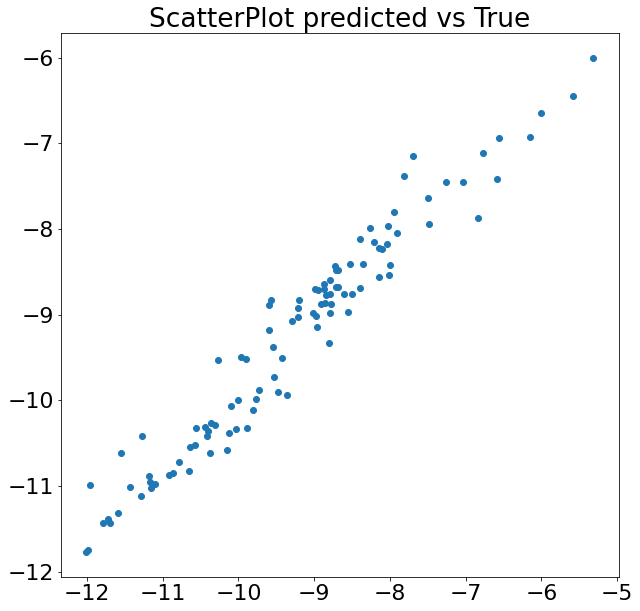

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02832
Feature:               commutersdensity, Score: 0.49401
Feature:                         depriv, Score: 0.02420
Feature:                 Ratio0200ver65, Score: 0.07988
Feature:         avg_wpm10_period1_2020, Score: 0.05122
Feature:          avg_wnh3_period1_2020, Score: 0.07169
Feature:        avg_wnmvoc_period1_2020, Score: 0.03375
Feature:           avg_wno_period1_2020, Score: 0.08875
Feature:           avg_wo3_period1_2020, Score: 0.04472
Feature:         avg_wpans_period1_2020, Score: 0.02576
Feature:          avg_wso2_period1_2020, Score: 0.03165
Feature:                  randomfeature, Score: 0.02605


<Figure size 432x288 with 0 Axes>

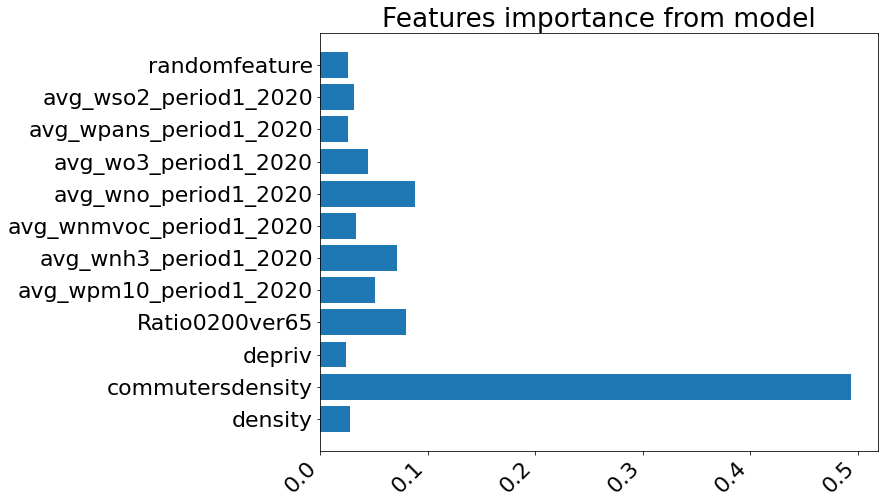

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.03386 +/- 0.00345
Feature:               commutersdensity, Score: 1.71970 +/- 0.29192
Feature:                         depriv, Score: 0.04439 +/- 0.00516
Feature:                 Ratio0200ver65, Score: 0.16717 +/- 0.02286
Feature:         avg_wpm10_period1_2020, Score: 0.14704 +/- 0.02491
Feature:          avg_wnh3_period1_2020, Score: 0.16298 +/- 0.02329
Feature:        avg_wnmvoc_period1_2020, Score: 0.04639 +/- 0.00518
Feature:           avg_wno_period1_2020, Score: 0.14119 +/- 0.02479
Feature:           avg_wo3_period1_2020, Score: 0.09658 +/- 0.00955
Feature:         avg_wpans_period1_2020, Score: 0.08343 +/- 0.01208
Feature:          avg_wso2_period1_2020, Score: 0.07127 +/- 0.00837
Feature:                  randomfeature, Score: 0.05114 +/- 0.00688


<Figure size 432x288 with 0 Axes>

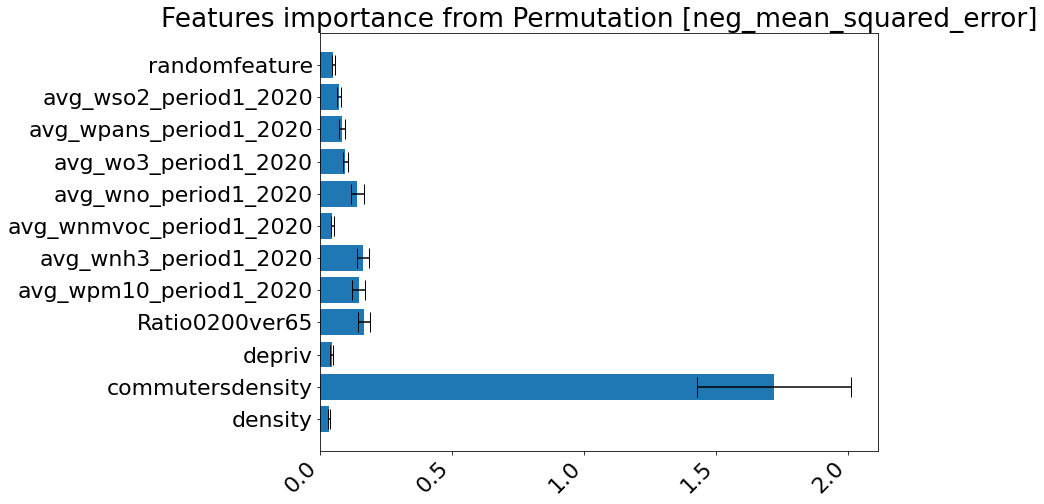

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.01550 +/- 0.00158
Feature:               commutersdensity, Score: 0.78696 +/- 0.13359
Feature:                         depriv, Score: 0.02031 +/- 0.00236
Feature:                 Ratio0200ver65, Score: 0.07650 +/- 0.01046
Feature:         avg_wpm10_period1_2020, Score: 0.06729 +/- 0.01140
Feature:          avg_wnh3_period1_2020, Score: 0.07458 +/- 0.01066
Feature:        avg_wnmvoc_period1_2020, Score: 0.02123 +/- 0.00237
Feature:           avg_wno_period1_2020, Score: 0.06461 +/- 0.01135
Feature:           avg_wo3_period1_2020, Score: 0.04420 +/- 0.00437
Feature:         avg_wpans_period1_2020, Score: 0.03818 +/- 0.00553
Feature:          avg_wso2_period1_2020, Score: 0.03261 +/- 0.00383
Feature:                  randomfeature, Score: 0.02340 +/- 0.00315


<Figure size 432x288 with 0 Axes>

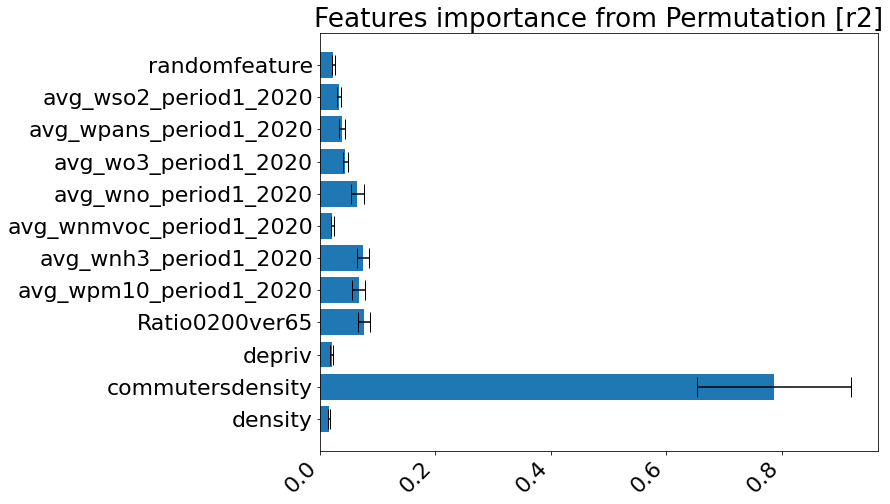

<Figure size 720x720 with 0 Axes>

((0.39269033821698757, 0.023648876804298554),
 (0.9968752609859449, 0.10632637932910671),
 0.3748667569205405,
 {'density': 0.012245476305050141,
  'commutersdensity': 0.6219193799087994,
  'depriv': 0.01605386935977739,
  'Ratio0200ver65': 0.06045503139011182,
  'avg_wpm10_period1_2020': 0.05317475970719088,
  'avg_wnh3_period1_2020': 0.05894183987825006,
  'avg_wnmvoc_period1_2020': 0.01677826431464802,
  'avg_wno_period1_2020': 0.051060877358730605,
  'avg_wo3_period1_2020': 0.03492881954089679,
  'avg_wpans_period1_2020': 0.03017217282842761,
  'avg_wso2_period1_2020': 0.025774172015391332,
  'randomfeature': 0.018495337392725967},
 {'density': 0.012245476305050112,
  'commutersdensity': 0.6219193799087996,
  'depriv': 0.016053869359777363,
  'Ratio0200ver65': 0.060455031390111796,
  'avg_wpm10_period1_2020': 0.05317475970719086,
  'avg_wnh3_period1_2020': 0.05894183987825004,
  'avg_wnmvoc_period1_2020': 0.016778264314647996,
  'avg_wno_period1_2020': 0.05106087735873058,
  'avg_w

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat", pout=sys.stdout, showplot=True)

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.1405250854441236
2  of  1200 MSE:  0.12240310149806331
3  of  1200 MSE:  0.2040499056245565
4  of  1200 MSE:  0.23834781223954266
5  of  1200 MSE:  0.454948248491502
6  of  1200 MSE:  0.5512727945821794
7  of  1200 MSE:  0.7097077656903418
8  of  1200 MSE:  0.7886267501384394
9  of  1200 MSE:  0.1890478272929978
10  of  1200 MSE:  0.20913670759900665
11  of  1200 MSE:  0.2255423464788091
12  of  1200 MSE:  0.2621767596238285
13  of  1200 MSE:  0.454948248491502
14  of  1200 MSE:  0.5512727945821794
15  of  1200 MSE:  0.7097077656903418
16  of  1200 MSE:  0.7886267501384394
17  of  1200 MSE:  0.31212422891382513
18  of  1200 MSE:  0.355454607333891
19  of  1200 MSE:  0.3437422492089045
20  of  1200 MSE:  0.3835880226138751
21  of  1200 MSE:  0.454948248491502
22  of  1200 MSE:  0.5512727945821794
23  of  1200 MSE:  0.7097077656903418
24  of  1200 MSE:  0.7886267501384394
25  of  1200 MSE:  0.4349418343148225
26  of  1200 MSE:  0.502997586224386
27  of  1200 MSE:  0.4

Training set average RMSE:  0.37948  0.02736 
    Test set average RMSE:  0.99747  0.10830 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.34977
                       R2:  0.94402


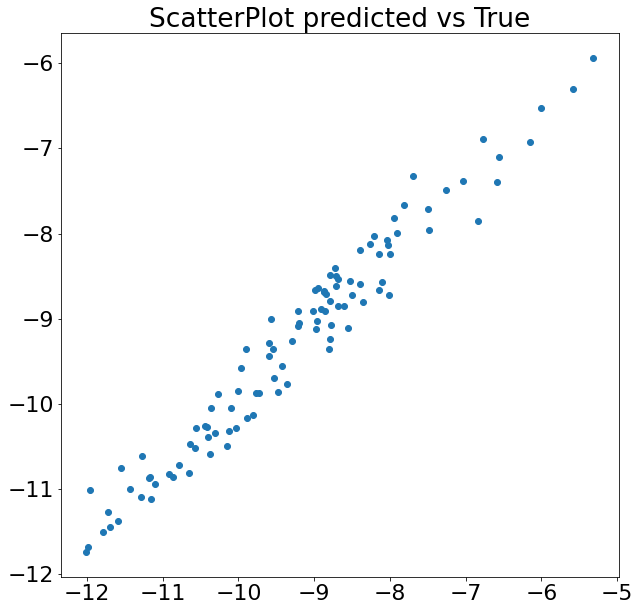

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03192
Feature:               commutersdensity, Score: 0.20557
Feature:                         depriv, Score: 0.09869
Feature:                 Ratio0200ver65, Score: 0.06017
Feature:         avg_wpm10_period1_2020, Score: 0.14607
Feature:          avg_wnh3_period1_2020, Score: 0.06367
Feature:        avg_wnmvoc_period1_2020, Score: 0.09505
Feature:           avg_wno_period1_2020, Score: 0.13633
Feature:           avg_wo3_period1_2020, Score: 0.05977
Feature:         avg_wpans_period1_2020, Score: 0.03793
Feature:          avg_wso2_period1_2020, Score: 0.03996
Feature:                  randomfeature, Score: 0.02487


<Figure size 432x288 with 0 Axes>

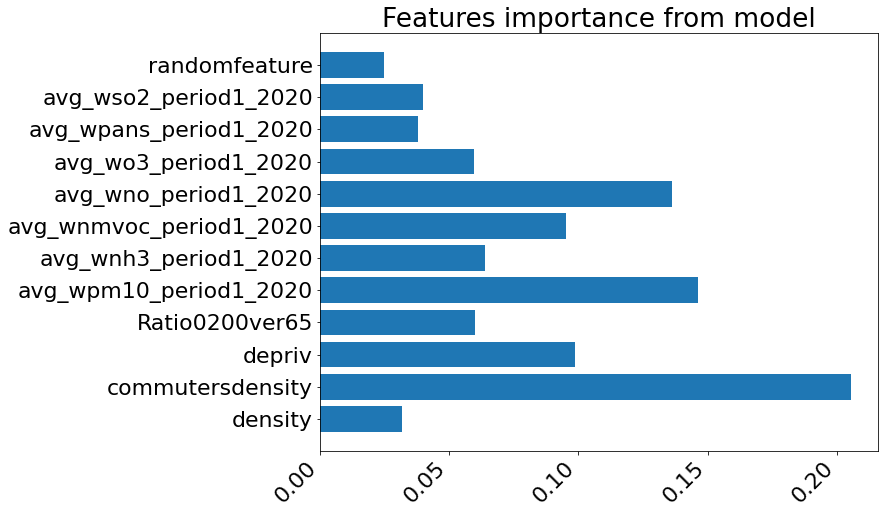

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.03722 +/- 0.00458
Feature:               commutersdensity, Score: 1.54708 +/- 0.25966
Feature:                         depriv, Score: 0.04986 +/- 0.00575
Feature:                 Ratio0200ver65, Score: 0.17704 +/- 0.02437
Feature:         avg_wpm10_period1_2020, Score: 0.12004 +/- 0.02015
Feature:          avg_wnh3_period1_2020, Score: 0.13681 +/- 0.02046
Feature:        avg_wnmvoc_period1_2020, Score: 0.05656 +/- 0.00703
Feature:           avg_wno_period1_2020, Score: 0.22089 +/- 0.03526
Feature:           avg_wo3_period1_2020, Score: 0.09897 +/- 0.00977
Feature:         avg_wpans_period1_2020, Score: 0.06177 +/- 0.00875
Feature:          avg_wso2_period1_2020, Score: 0.07557 +/- 0.00924
Feature:                  randomfeature, Score: 0.04789 +/- 0.00550


<Figure size 432x288 with 0 Axes>

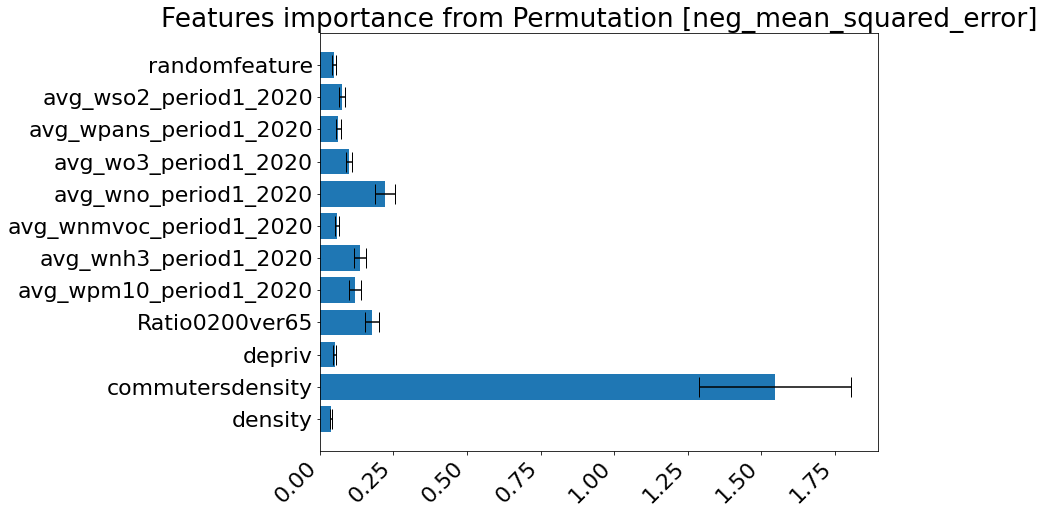

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.01703 +/- 0.00210
Feature:               commutersdensity, Score: 0.70797 +/- 0.11882
Feature:                         depriv, Score: 0.02282 +/- 0.00263
Feature:                 Ratio0200ver65, Score: 0.08102 +/- 0.01115
Feature:         avg_wpm10_period1_2020, Score: 0.05493 +/- 0.00922
Feature:          avg_wnh3_period1_2020, Score: 0.06261 +/- 0.00936
Feature:        avg_wnmvoc_period1_2020, Score: 0.02588 +/- 0.00322
Feature:           avg_wno_period1_2020, Score: 0.10108 +/- 0.01614
Feature:           avg_wo3_period1_2020, Score: 0.04529 +/- 0.00447
Feature:         avg_wpans_period1_2020, Score: 0.02827 +/- 0.00400
Feature:          avg_wso2_period1_2020, Score: 0.03458 +/- 0.00423
Feature:                  randomfeature, Score: 0.02191 +/- 0.00252


<Figure size 432x288 with 0 Axes>

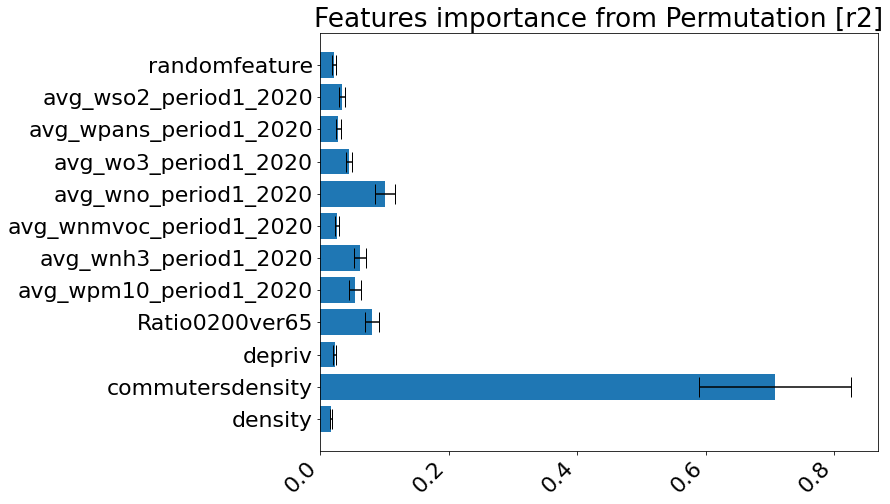

<Figure size 720x720 with 0 Axes>

((0.379477638591344, 0.027359844647903316),
 (0.9974743109677421, 0.10829512636172818),
 0.3497685819382733,
 {'density': 0.014152507283192041,
  'commutersdensity': 0.5883109911714013,
  'depriv': 0.01896177619448874,
  'Ratio0200ver65': 0.06732506806611724,
  'avg_wpm10_period1_2020': 0.04564653812579289,
  'avg_wnh3_period1_2020': 0.052026172735241176,
  'avg_wnmvoc_period1_2020': 0.021507400233428616,
  'avg_wno_period1_2020': 0.08399657017353604,
  'avg_wo3_period1_2020': 0.03763617112434408,
  'avg_wpans_period1_2020': 0.023490629978396113,
  'avg_wso2_period1_2020': 0.028736481968348153,
  'randomfeature': 0.018209692945713597},
 {'density': 0.014152507283192046,
  'commutersdensity': 0.5883109911714012,
  'depriv': 0.018961776194488734,
  'Ratio0200ver65': 0.06732506806611722,
  'avg_wpm10_period1_2020': 0.045646538125792877,
  'avg_wnh3_period1_2020': 0.05202617273524117,
  'avg_wnmvoc_period1_2020': 0.021507400233428616,
  'avg_wno_period1_2020': 0.08399657017353603,
  'avg_w

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_opt", showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.41030  0.02539 
    Test set average RMSE:  1.07899  0.09297 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.39322
                       R2:  0.92924


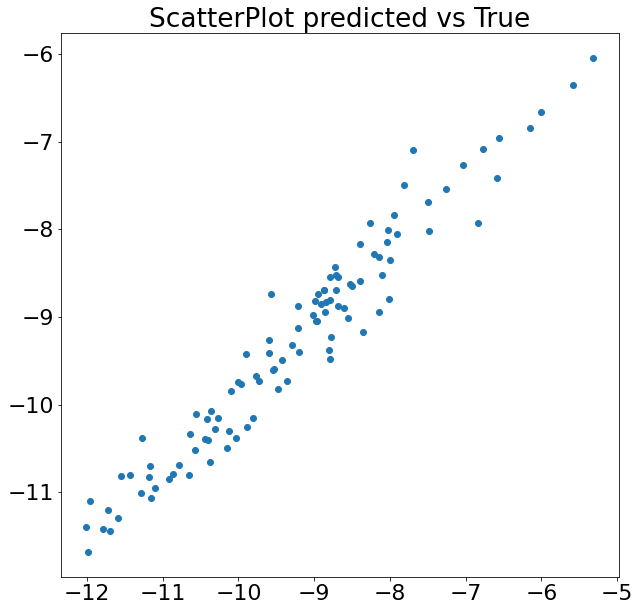

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02683
Feature:                         depriv, Score: 0.18746
Feature:                 Ratio0200ver65, Score: 0.07444
Feature:         avg_wpm10_period1_2020, Score: 0.12438
Feature:          avg_wnh3_period1_2020, Score: 0.08587
Feature:        avg_wnmvoc_period1_2020, Score: 0.09072
Feature:           avg_wno_period1_2020, Score: 0.21888
Feature:           avg_wo3_period1_2020, Score: 0.05413
Feature:         avg_wpans_period1_2020, Score: 0.05108
Feature:          avg_wso2_period1_2020, Score: 0.05878
Feature:                  randomfeature, Score: 0.02741


<Figure size 432x288 with 0 Axes>

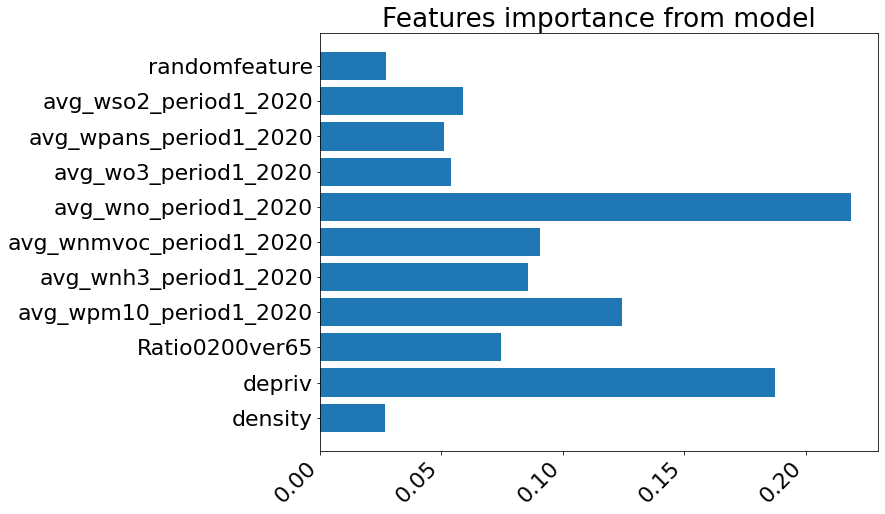

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.03741 +/- 0.00502
Feature:                         depriv, Score: 0.47660 +/- 0.07817
Feature:                 Ratio0200ver65, Score: 0.12471 +/- 0.01483
Feature:         avg_wpm10_period1_2020, Score: 0.17597 +/- 0.03041
Feature:          avg_wnh3_period1_2020, Score: 0.20362 +/- 0.02814
Feature:        avg_wnmvoc_period1_2020, Score: 0.18834 +/- 0.03314
Feature:           avg_wno_period1_2020, Score: 0.46234 +/- 0.06985
Feature:           avg_wo3_period1_2020, Score: 0.13400 +/- 0.01324
Feature:         avg_wpans_period1_2020, Score: 0.14226 +/- 0.01971
Feature:          avg_wso2_period1_2020, Score: 0.07435 +/- 0.00900
Feature:                  randomfeature, Score: 0.04449 +/- 0.00577


<Figure size 432x288 with 0 Axes>

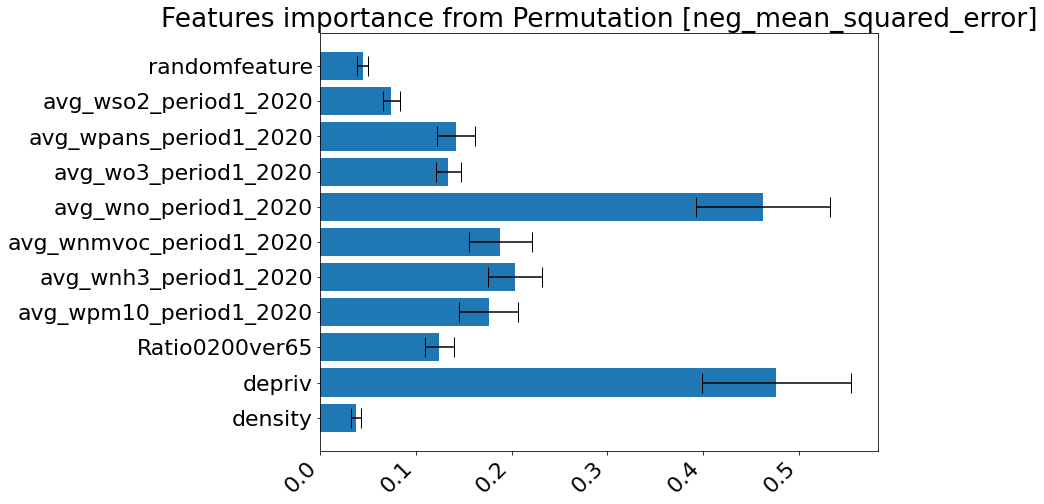

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.01712 +/- 0.00229
Feature:                         depriv, Score: 0.21810 +/- 0.03577
Feature:                 Ratio0200ver65, Score: 0.05707 +/- 0.00679
Feature:         avg_wpm10_period1_2020, Score: 0.08053 +/- 0.01392
Feature:          avg_wnh3_period1_2020, Score: 0.09318 +/- 0.01288
Feature:        avg_wnmvoc_period1_2020, Score: 0.08619 +/- 0.01516
Feature:           avg_wno_period1_2020, Score: 0.21158 +/- 0.03197
Feature:           avg_wo3_period1_2020, Score: 0.06132 +/- 0.00606
Feature:         avg_wpans_period1_2020, Score: 0.06510 +/- 0.00902
Feature:          avg_wso2_period1_2020, Score: 0.03402 +/- 0.00412
Feature:                  randomfeature, Score: 0.02036 +/- 0.00264


<Figure size 432x288 with 0 Axes>

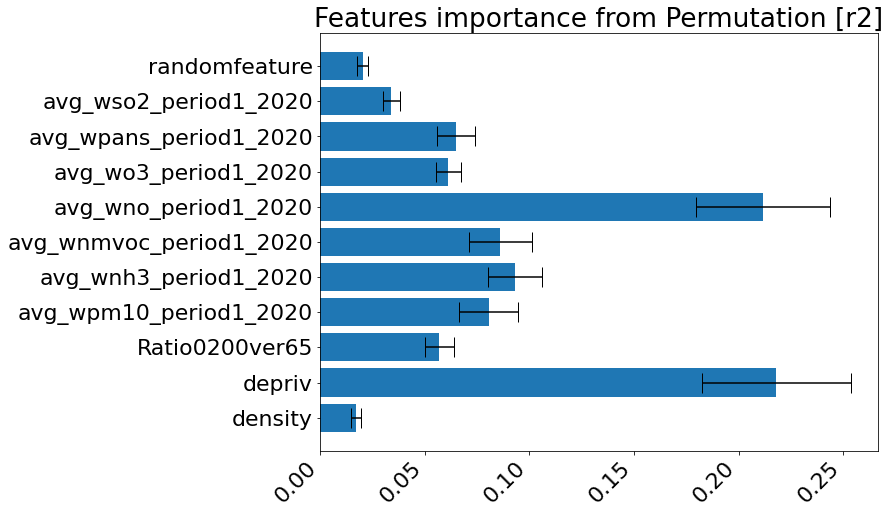

<Figure size 720x720 with 0 Axes>

((0.4103039328697492, 0.025387875284717438),
 (1.0789856553542454, 0.09297081773013736),
 0.39321961709387415,
 {'density': 0.01812298266819511,
  'depriv': 0.23090100587992793,
  'Ratio0200ver65': 0.06041835967105625,
  'avg_wpm10_period1_2020': 0.08525393476091943,
  'avg_wnh3_period1_2020': 0.09864714152171199,
  'avg_wnmvoc_period1_2020': 0.09124671161029373,
  'avg_wno_period1_2020': 0.223992526519034,
  'avg_wo3_period1_2020': 0.06491988248337668,
  'avg_wpans_period1_2020': 0.06892207680314105,
  'avg_wso2_period1_2020': 0.03602144206856347,
  'randomfeature': 0.02155393601378034},
 {'density': 0.018122982668195113,
  'depriv': 0.23090100587992796,
  'Ratio0200ver65': 0.060418359671056236,
  'avg_wpm10_period1_2020': 0.08525393476091941,
  'avg_wnh3_period1_2020': 0.09864714152171203,
  'avg_wnmvoc_period1_2020': 0.09124671161029371,
  'avg_wno_period1_2020': 0.2239925265190341,
  'avg_wo3_period1_2020': 0.06491988248337668,
  'avg_wpans_period1_2020': 0.06892207680314105,
  'av

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_nocommut", pout=sys.stdout, showplot=True)

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.154621667267453
2  of  1200 MSE:  0.1418263809770502
3  of  1200 MSE:  0.21074933192555426
4  of  1200 MSE:  0.25463328538175783
5  of  1200 MSE:  0.4929163096650623
6  of  1200 MSE:  0.5953652359244156
7  of  1200 MSE:  0.7855418957925433
8  of  1200 MSE:  0.8546959096351967
9  of  1200 MSE:  0.20722959759884838
10  of  1200 MSE:  0.231667939987148
11  of  1200 MSE:  0.23535565283736676
12  of  1200 MSE:  0.285237553715053
13  of  1200 MSE:  0.4929163096650623
14  of  1200 MSE:  0.5953652359244156
15  of  1200 MSE:  0.7855418957925433
16  of  1200 MSE:  0.8546959096351967
17  of  1200 MSE:  0.3372313434459493
18  of  1200 MSE:  0.3805007044039264
19  of  1200 MSE:  0.36303505313798823
20  of  1200 MSE:  0.41027643639297007
21  of  1200 MSE:  0.4929163096650623
22  of  1200 MSE:  0.5953652359244156
23  of  1200 MSE:  0.7855418957925433
24  of  1200 MSE:  0.8546959096351967
25  of  1200 MSE:  0.46104739906400943
26  of  1200 MSE:  0.528250665765203
27  of  1200 MSE: 

Training set average RMSE:  0.38195  0.02024 
    Test set average RMSE:  1.06051  0.10704 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36918
                       R2:  0.93763


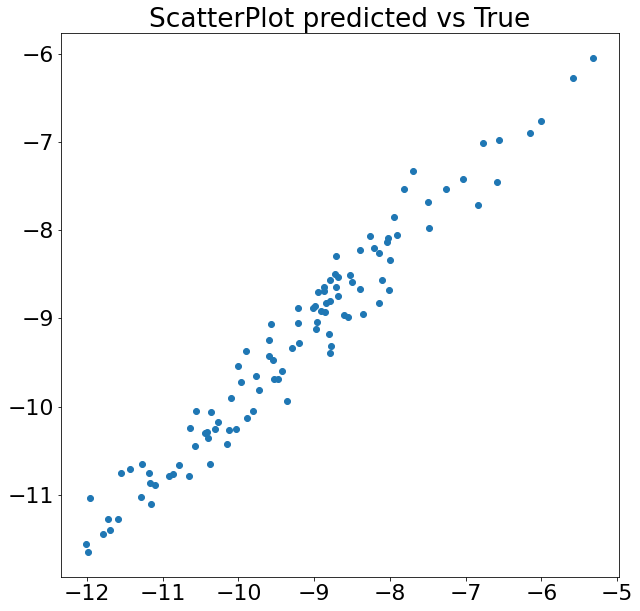

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03881
Feature:                         depriv, Score: 0.13360
Feature:                 Ratio0200ver65, Score: 0.06372
Feature:         avg_wpm10_period1_2020, Score: 0.12433
Feature:          avg_wnh3_period1_2020, Score: 0.11505
Feature:        avg_wnmvoc_period1_2020, Score: 0.12978
Feature:           avg_wno_period1_2020, Score: 0.16662
Feature:           avg_wo3_period1_2020, Score: 0.09052
Feature:         avg_wpans_period1_2020, Score: 0.05479
Feature:          avg_wso2_period1_2020, Score: 0.05378
Feature:                  randomfeature, Score: 0.02900


<Figure size 432x288 with 0 Axes>

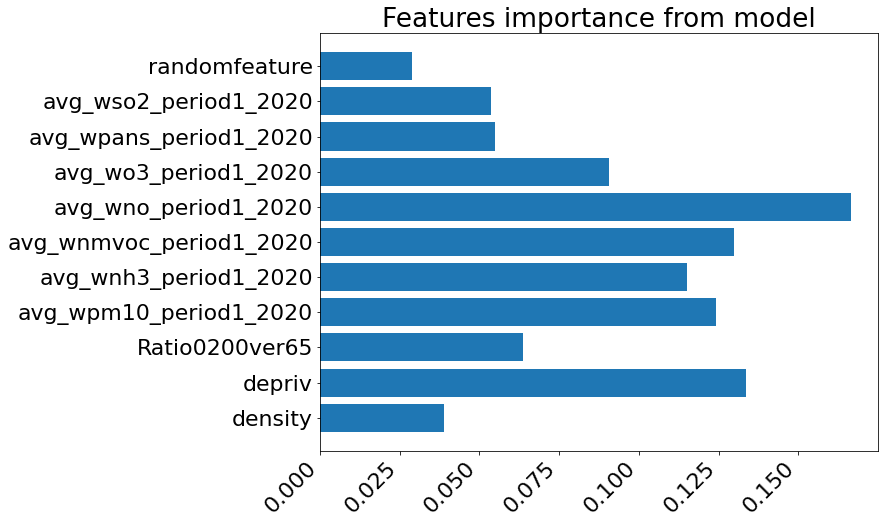

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04032 +/- 0.00516
Feature:                         depriv, Score: 0.51222 +/- 0.08520
Feature:                 Ratio0200ver65, Score: 0.13715 +/- 0.01617
Feature:         avg_wpm10_period1_2020, Score: 0.21108 +/- 0.03673
Feature:          avg_wnh3_period1_2020, Score: 0.19146 +/- 0.02711
Feature:        avg_wnmvoc_period1_2020, Score: 0.17692 +/- 0.03309
Feature:           avg_wno_period1_2020, Score: 0.43837 +/- 0.06585
Feature:           avg_wo3_period1_2020, Score: 0.11740 +/- 0.01148
Feature:         avg_wpans_period1_2020, Score: 0.13632 +/- 0.02115
Feature:          avg_wso2_period1_2020, Score: 0.07852 +/- 0.01032
Feature:                  randomfeature, Score: 0.05020 +/- 0.00664


<Figure size 432x288 with 0 Axes>

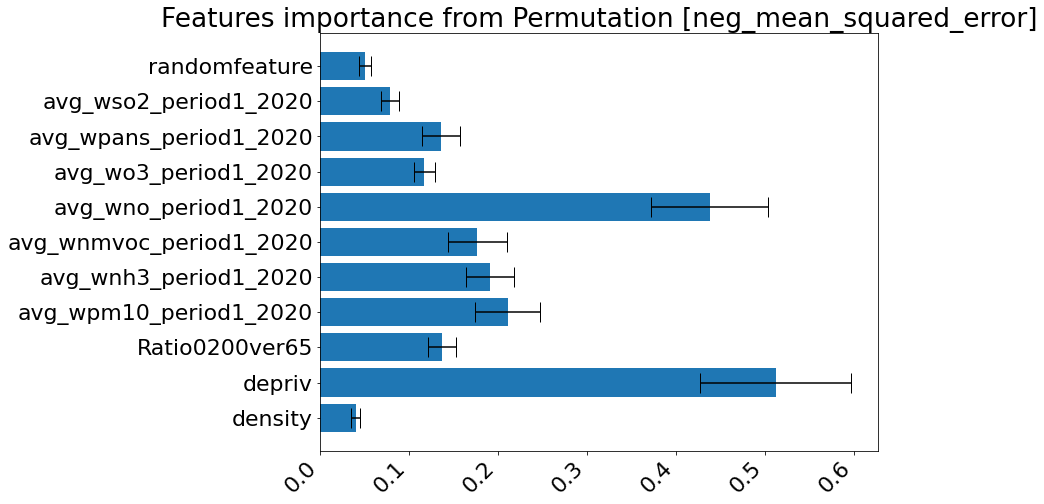

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.01845 +/- 0.00236
Feature:                         depriv, Score: 0.23440 +/- 0.03899
Feature:                 Ratio0200ver65, Score: 0.06276 +/- 0.00740
Feature:         avg_wpm10_period1_2020, Score: 0.09659 +/- 0.01681
Feature:          avg_wnh3_period1_2020, Score: 0.08761 +/- 0.01240
Feature:        avg_wnmvoc_period1_2020, Score: 0.08096 +/- 0.01514
Feature:           avg_wno_period1_2020, Score: 0.20060 +/- 0.03013
Feature:           avg_wo3_period1_2020, Score: 0.05372 +/- 0.00525
Feature:         avg_wpans_period1_2020, Score: 0.06238 +/- 0.00968
Feature:          avg_wso2_period1_2020, Score: 0.03593 +/- 0.00472
Feature:                  randomfeature, Score: 0.02297 +/- 0.00304


<Figure size 432x288 with 0 Axes>

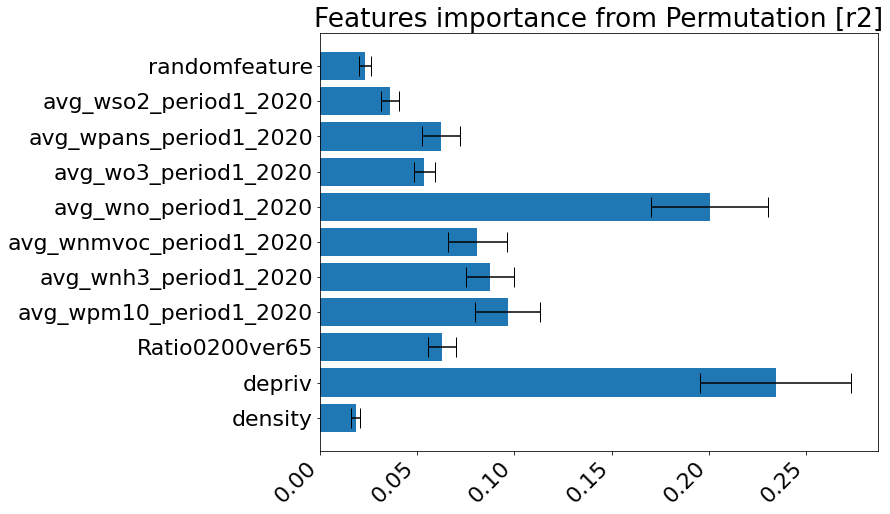

<Figure size 720x720 with 0 Axes>

((0.3819506401320045, 0.020243368270574106),
 (1.0605089106978054, 0.10704048864529879),
 0.36918118325549687,
 {'density': 0.019291735473506485,
  'depriv': 0.24508538437232674,
  'Ratio0200ver65': 0.0656230540195796,
  'avg_wpm10_period1_2020': 0.1009962942122131,
  'avg_wnh3_period1_2020': 0.09160876420425945,
  'avg_wnmvoc_period1_2020': 0.08465103398758107,
  'avg_wno_period1_2020': 0.20975000323070359,
  'avg_wo3_period1_2020': 0.056174032356401817,
  'avg_wpans_period1_2020': 0.06522767925399811,
  'avg_wso2_period1_2020': 0.0375707265363132,
  'randomfeature': 0.024021292353116855},
 {'density': 0.019291735473506468,
  'depriv': 0.24508538437232671,
  'Ratio0200ver65': 0.0656230540195796,
  'avg_wpm10_period1_2020': 0.10099629421221305,
  'avg_wnh3_period1_2020': 0.09160876420425944,
  'avg_wnmvoc_period1_2020': 0.08465103398758109,
  'avg_wno_period1_2020': 0.2097500032307036,
  'avg_wo3_period1_2020': 0.056174032356401817,
  'avg_wpans_period1_2020': 0.0652276792539981,
  'av

In [14]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_nocommut_opt", showplot=True, optimisedparams=bestf)